In [1]:
import argparse
import os
import random

import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Dataset overview

In this problem we are building 15-way multi-class classifiers for a fruit classification task. The training and validation sets are stored in the .pkl files provided. See the hw5.pdf file we have provided for details.

In each dataset, we provide the following:
- 'images': the raw RGB images
- 'feats': 15 dimensional condensed representations of each image (that were precomputed by using a pretrained vision transformer + PCA)
- 'labels': an integer value between 0 and 14. The integer to class mapping is provided below in the variable 'idx_to_class'.

We first create a simple python dictionary that maps integers to textual class labels that can be useful for debugging.

In [2]:
idx_to_class = {0: 'Apple', 1: 'Banana', 2: 'Carambola', 3: 'Guava', 4: 'Kiwi', 5: 'Mango', 6: 'Orange', 7: 'Peach', 8: 'Pear', 9: 'Persimmon', 10: 'Pitaya', 11: 'Plum', 12: 'Pomegranate', 13: 'Tomatoes', 14: 'Muskmelon'}
print(idx_to_class)

{0: 'Apple', 1: 'Banana', 2: 'Carambola', 3: 'Guava', 4: 'Kiwi', 5: 'Mango', 6: 'Orange', 7: 'Peach', 8: 'Pear', 9: 'Persimmon', 10: 'Pitaya', 11: 'Plum', 12: 'Pomegranate', 13: 'Tomatoes', 14: 'Muskmelon'}


Next, we load the .pkl files that load as python dictionaries.

In [3]:
with open('datasets/train.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

In [4]:
with open('datasets/val.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

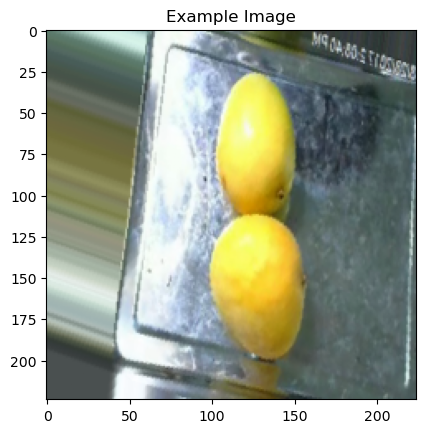

In [5]:
# We can plot the images this way. This will be quite useful for debugging.
plt.figure()
plt.title('Example Image')
plt.imshow(train_dataset['images'][0])
plt.show()

In [6]:
print("Examples Features shape:", train_dataset['feats'][0].shape)

Examples Features shape: (15,)


In [7]:
print("Example image label:", idx_to_class[train_dataset['labels'][0]])

Example image label: Mango


In [8]:
print(train_dataset['feats'][0])
print(np.array(train_dataset['labels']).shape)
print(np.array(train_dataset['images']).reshape(np.array(train_dataset['labels']).size,150528).shape)


[-0.73493075  0.35717848  1.3297853   0.16270295  1.7608238  -1.1582989
  0.5272275  -0.54177004  0.27921718 -0.02514401  0.66478443  0.25313285
  0.15742105  0.21063007 -0.09196111]
(9876,)
(9876, 150528)


## Part 2(a): Logistic Regression

Implement Logistic Regression from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

In [9]:
y_train = np.array(train_dataset['labels'])
X_train = np.array(train_dataset['feats'])
y_val = np.array(val_dataset['labels'])
X_val = np.array(val_dataset['feats'])

print(X_val.shape)

(2116, 15)


In [10]:
# TODO: Implement multinomial logistic regression
# TODO: stochastic gradient descent (SGD) for Logistic regression
from sklearn.base import BaseEstimator, ClassifierMixin

class LogRegMine(BaseEstimator, ClassifierMixin):
    # encode integer labels to binary vectors
    def yMatrix(self, y, num_class):
        Y = np.zeros((len(y), num_class))
        Y[range(len(y)), y] = 1
        return Y

    # minibatch iterator
    def iterate_minibatches(self, X, y, Y, batchsize, shuffle=False):
        assert X.shape[0] == y.shape[0]
        if shuffle:
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
        for start_idx in range(0, X.shape[0] - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            yield X[excerpt], y[excerpt], Y[excerpt]

    def softmax(self, x):
        e = np.exp(x - np.max(x))  # prevent overflow
        if e.ndim == 1:
            return e / np.sum(e, axis=0)
        else:  
            return e / np.array([np.sum(e, axis=1)]).T 

    def __init__(self, batch_size = 100, lr = 1.0e-1, eta = 0.3, eps = 0.0005, 
                           max_epoch = 500, print_epoch = 20, lr_epoch = 10, stop_epoch = 20, 
                           bias = True, shuffle = True, verbose = True):
        self.batch_size = batch_size
        self.lr = lr
        self.eta = eta
        self.eps = eps
        self.max_epoch = max_epoch
        self.print_epoch = print_epoch
        self.lr_epoch = lr_epoch
        self.stop_epoch = stop_epoch
        self.bias = bias
        self.shuffle = shuffle
        self.verbose = verbose
        self.W = np.zeros(1)
        self.b = np.zeros(1)
        
    # stochastic gradient descent (SGD) for Logistic regression
    def fit(self, X, y):
        ncvg = True
        epoch = 0
        n, d = X.shape
        loss = []
        num_class = len(np.unique(y))
        Y = self.yMatrix(y, num_class)
        self.W = np.zeros((d, num_class))
        
        if self.bias:
            X = np.concatenate([X, np.ones((n, 1))], axis=1)
            self.W = np.concatenate([self.W, np.ones((1, num_class))], axis = 0)
    
        # optimization loop	
        while ncvg and epoch < self.max_epoch:
            
            loss_epoch = 0.0
            for Xb, yb, Yb in self.iterate_minibatches(X, y, Y, self.batch_size, self.shuffle):
                
                # minibatch gradient descent
                nb = len(yb)
                logits = self.softmax(np.matmul(Xb, self.W))
                grad = np.matmul(Xb.T, Yb - logits) - self.eta * self.W
                self.W = self.W + (self.lr / float(nb)) * grad
                loss_epoch += -np.sum(np.log(logits[range(nb), yb]))
                
            loss.append(loss_epoch / float(n))
            
            # half lr if not improving in lr_epoch epochs
            if epoch > self.lr_epoch:
                if loss[epoch - self.lr_epoch] <= loss[epoch] - self.eps:
                    self.lr *= 0.5
                    print('halfing learning rate to', self.lr)
            
            # stop if not improving in stop_epoch epochs
            if epoch > self.stop_epoch:
                if loss[epoch - self.stop_epoch] <= loss[epoch] - self.eps or abs(loss[epoch] - loss[epoch-1]) <= self.eps:                
                    ncvg = False
                    break
                
            epoch += 1
        
        #print('epoch', epoch-1, ': loss =', loss[-1])
        
        if self.bias:
            self.b = self.W[-1]
            self.W = self.W[:d]
        else:
            self.b = np.zeros(num_class)

    def predict(self, X):
        if self.bias:
            pred = np.argmax(np.matmul(X, self.W) + self.b, axis = 1)
        else:
            pred = np.argmax(np.matmul(X, self.W), axis = 1)
        return pred

In [11]:
# TODO: Report accuracy on training and validation sets
def precision(pred, y):
    return sum(np.equal(pred, y)) / float(len(y))

# Define the parameter space for the GridSearch
param_grid = {
    'batch_size': [1,20,50,100,500,1000],
    'lr': [0.001, 0.01, 0.1],
    'eta': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_epoch': [500],
    'print_epoch': [500],
    'lr_epoch':[20, 50, 100],
    'stop_epoch':[20],
    'bias':[True],
    'shuffle':[False],
    'verbose':[False]
}

X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

# Create the split index (-1 for training set, 0 for validation set)
test_fold = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_val.shape[0])]
ps = PredefinedSplit(test_fold=test_fold)
# Initialize your custom model
my_model = LogRegMine()

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=my_model, param_grid=param_grid, cv=ps, scoring='accuracy', return_train_score=True, verbose=0)

# Fit GridSearchCV
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)


/var/folders/c9/3q_3q36n4k9_t4gnwrhyd7s80000gn/T/ipykernel_49908/1574790776.py:74: RuntimeWarning: divide by zero encountered in log
  loss_epoch += -np.sum(np.log(logits[range(nb), yb]))
/var/folders/c9/3q_3q36n4k9_t4gnwrhyd7s80000gn/T/ipykernel_49908/1574790776.py:72: RuntimeWarning: overflow encountered in multiply
  grad = np.matmul(Xb.T, Yb - logits) - self.eta * self.W
/var/folders/c9/3q_3q36n4k9_t4gnwrhyd7s80000gn/T/ipykernel_49908/1574790776.py:26: RuntimeWarning: invalid value encountered in subtract
  e = np.exp(x - np.max(x))  # prevent overflow
/var/folders/c9/3q_3q36n4k9_t4gnwrhyd7s80000gn/T/ipykernel_49908/1574790776.py:74: RuntimeWarning: divide by zero encountered in log
  loss_epoch += -np.sum(np.log(logits[range(nb), yb]))
/var/folders/c9/3q_3q36n4k9_t4gnwrhyd7s80000gn/T/ipykernel_49908/1574790776.py:72: RuntimeWarning: overflow encountered in multiply
  grad = np.matmul(Xb.T, Yb - logits) - self.eta * self.W
/var/folders/c9/3q_3q36n4k9_t4gnwrhyd7s80000gn/T/ipykernel_

Best parameters: {'batch_size': 50, 'bias': True, 'eta': 0.001, 'lr': 0.1, 'lr_epoch': 20, 'max_epoch': 500, 'print_epoch': 500, 'shuffle': False, 'stop_epoch': 20, 'verbose': False}


In [12]:
# Access the best score and corresponding training score
best_validation_score = grid_search.best_score_
best_index = grid_search.best_index_
best_training_score = grid_search.cv_results_['mean_train_score'][best_index]

print(f"Best Validation Score: {best_validation_score}")
print(f"Corresponding Training Score: {best_training_score}")

Best Validation Score: 0.9026465028355387
Corresponding Training Score: 0.9141352774402592


## Part 2(b): Random Forest/GBDT 

Implement a random forest or GBDT from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

In [58]:
class loss(object):
    '''Loss class for mse. As for mse, pred function is pred=score.'''
    def pred(self,X_test,trees,log_threshold):
        return 0
    def g(self, y_true, pred):
        return 0
    def h(self, pred):
        return 0

class logistic(loss):
    '''Loss class for log loss. As for log loss, pred function is logistic transformation.'''
    def pred(self,X_test,trees,log_threshold):
        predictions = []
        #print(len(trees))
        for test in X_test:
            temp = np.zeros(len(trees))
            for i in range(len(trees)):
                tree = trees[i]
                curr_node = tree.root_node
                while(curr_node.is_leaf == False):
                    curr_node = curr_node.forward(test)
                temp[i] = curr_node.weight
            min = np.min(temp)
            max = np.max(temp)
            #print(min)
            #print(max)
            if max != min :
                temp = (temp - min)/(max - min)
            temp = np.rint(temp)
            unique, counts = np.unique(temp, return_counts=True)
            #print(unique)
            if(unique.size > 1):
                if counts[1] > counts[0] :
                    predictions.append(1.0)
                else :
                    predictions.append(0.0)
            else :
                predictions.append(unique[0])
        return predictions

    def g(self, y_true, pred):
        return ((((1-y_true)*np.exp(pred)) - y_true)/(np.exp(pred) + 1))

    def h(self, y_true, pred):
        return (np.exp(pred)/((np.exp(pred) + 1)*(np.exp(pred) + 1)))*np.ones(y_true.shape)

# TODO: class of a node on a tree
class TreeNode(object):
    '''
    Data structure that are used for storing a node on a tree.
    
    A tree is presented by a set of nested TreeNodes,
    with one TreeNode pointing two child TreeNodes,
    until a tree leaf is reached.
    
    A node on a tree can be either a leaf node or a non-leaf node.
    '''
    
    #TODO
    def __init__(self, X1, X2, index_y, threshold, value_y, is_leaf):
        self.is_leaf = is_leaf
        self.left_child = X1
        self.right_child = X2
        self.feature_index = index_y
        self.threshold = threshold
        self.weight = value_y

    def forward(self, x):
        #print(self.weight)
        #print(self.feature_index)
        #print(self.threshold)
        #print(self.is_leaf)
        #print(self.left_child.is_leaf)
        #print(self.right_child.is_leaf)
        if self.is_leaf == True :
            raise RuntimeError('This is a leaf node and you cannot forward from it')
        elif x[self.feature_index] < self.threshold:
            #print(self.left_child.is_leaf)
            return self.left_child
        else :
            #print(self.right_child.is_leaf)
            return self.right_child

# TODO: class of single tree
class Tree(object):
    '''
    Class of a single decision tree in GBDT

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        max_depth: The maximum depth of the tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf prediction, also known as lambda.
        gamma: The regularization coefficient for number of TreeNode, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule,
            rf = 0 means we are training a GBDT.
    '''
    
    def __init__(self, root_node = None, n_threads = None, 
                 max_depth = 3, min_sample_split = 10,
                 lamda = 1, gamma = 0, pred = 0):
        self.n_threads = n_threads
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.root_node = root_node
        self.lamda = lamda
        self.gamma = gamma
        self.pred = pred
        self.treenodes = []

    def fit(self, X, y, loss):
        '''
        train is the training data matrix, and must be numpy array (an n_train x m matrix).
        g and h are gradient and hessian respectively.
        '''
        g = loss.g(y, self.pred)
        h = loss.h(y, self.pred)
        #print(g)
        #print(h)
        self.root_node = self.construct_tree(X, y, g, h, 0)
        #print(self.root_node.weight)
        return self

    def split_dataset(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] < threshold
        right_mask = X[:, feature_index] >= threshold
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def calculate_gain(self, g_l, h_l, g_r, h_r):
        G_l_tot = g_l.sum()
        G_r_tot = g_r.sum()
        H_l_tot = h_l.sum()
        H_r_tot = h_r.sum()
        gain = (0.5)*(((G_l_tot)*(G_l_tot)/(H_l_tot + self.lamda)) + ((G_r_tot)*(G_r_tot)/(H_r_tot + self.lamda)) - (((G_l_tot+G_r_tot)*(G_l_tot+G_r_tot))/(H_l_tot + H_r_tot+ self.lamda))) - self.gamma
        return gain
        
    def find_threshold(self, g, h, X, y, feature_index):
        '''
        Given a particular feature $p_j$,
        return the best split threshold $\tau_j$ together with the gain that is achieved.
        '''
        best_gain = 0
        best_threshold = 0
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            X_left, X_right, y_left, y_right = self.split_dataset(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            left_mask = X[:, feature_index] < threshold
            right_mask = X[:, feature_index] >= threshold
            gain = self.calculate_gain(g[left_mask], h[left_mask], g[right_mask], h[right_mask])
            #print("Gain : " +str(gain))
            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold
        return [threshold, best_gain]
        
    def construct_tree(self, X, y, g, h, current_depth):
        '''
        Node Addition, which is recursively used to grow a tree.
        First we should check if we should stop further splitting.
        
        The stopping conditions include:
            1. tree reaches max_depth $d_{max}$
            2. The number of sample points at current node is less than min_sample_split, i.e., $n_{min}$
            3. gain <= 0
        '''
        if current_depth > self.max_depth or y.size < self.min_sample_split :
            return None
        best_feature, threshold, best_gain = self.find_best_decision_rule(X, y, g, h)
        #print("best_feature : " + str(best_feature))
        #print("threshold : " + str(threshold))
        #print("best_gain : " + str(best_gain))
        if best_gain == 0 : 
            return None
        #print(X[:, best_feature])
        left_mask = X[:, best_feature] < threshold
        right_mask = X[:, best_feature] >= threshold
        node_left = self.construct_tree(X[left_mask], y[left_mask], g[left_mask], h[left_mask], current_depth + 1)
        node_right = self.construct_tree(X[right_mask], y[right_mask], g[right_mask], h[right_mask], current_depth + 1)
        h_val = h.sum()
        weight = -(g.sum()/(h_val + self.lamda))
        is_leaf = False
        if node_left is None and node_right is not None :
            node_left = TreeNode(None, None, 0, 0, weight, True)
        elif node_right is None and node_left is not None :
            node_right = TreeNode(None, None, 0, 0, weight, True)
        elif node_right is None and node_left is None :
            is_leaf = True
        node = TreeNode(node_left, node_right, best_feature, threshold, weight, is_leaf)
        self.treenodes.append(node)
        #print(node)
        return node

    def find_best_decision_rule(self, X, y, g, h):
        '''
        Return the best decision rule [feature, treshold], i.e., $(p_j, \tau_j)$ on a node j, 
        train is the training data assigned to node j
        g and h are the corresponding 1st and 2nd derivatives for each data point in train
        g and h should be vectors of the same length as the number of data points in train
        
        for each feature, we find the best threshold by find_threshold(),
        a [threshold, best_gain] list is returned for each feature.
        Then we select the feature with the largest best_gain,
        and return the best decision rule [feature, treshold] together with its gain.
        '''
        best_gain = 0
        best_threshold = 0 
        best_feature = 0
        for feature_index in range(X.shape[1]):
            #print("Feature " + str(feature_index))
            threshold, gain = self.find_threshold(g, h, X, y, feature_index)
            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold
                best_feature = feature_index
        return best_feature, threshold, best_gain

# TODO: class of Random Forest
class RF(object):
    '''
    Class of Random Forest
    
    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth d_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule.
        num_trees: Number of trees.
    '''
    def __init__(self,log_threshold = 0.5,
        n_threads = 0, loss = 'mse',
        max_depth = 3, min_sample_split = 10, 
        lamda = 1, gamma = 0,
        rf = 0.99, num_trees = 100):
        self.log_threshold = log_threshold
        self.n_threads = n_threads
        self.loss = logistic()
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.num_trees = num_trees
        self.trees = []

    def fit(self, X, y):
        # X is n x m 2d numpy array
        # y is n-dim 1d array
        num_samples, num_features = X.shape
        for i in range(self.num_trees):
            #print ("Tree : " + str(i))
            m_rf = (int)(np.ceil(self.rf*num_features))
            m_rf_indices = np.random.choice(num_features, m_rf, replace=False)
            n_rf_indices = np.random.choice(num_samples, num_samples, replace=True)
            XTree = X[n_rf_indices][:,m_rf_indices]
            #print(XTree.shape)
            yTree = y[n_rf_indices]
            prediction = 0
            tree = Tree(None, self.n_threads, self.max_depth, self.min_sample_split,self.lamda, self.gamma, prediction)
            tree = tree.fit(XTree, yTree, self.loss)
            self.trees.append(tree)
        return self

    # test is the input to the model
    def predict(self, X_test):
        return self.loss.pred(X_test, self.trees, self.log_threshold)

In [65]:
# TODO: Report accuracy on training and validation sets
def accuracy(pred, y):
    dataset_size = y.size
    correct_predictions = 0
    #print(pred)
    #print(y)
    for i in range(dataset_size):
        if y[i] == (pred[i]):
            correct_predictions += 1
    precision = (correct_predictions/dataset_size)*100
    return precision

RF_regression = RF(log_threshold = 0.5, n_threads = 0, loss = 'class', max_depth = 6, min_sample_split = 10, lamda = 1, gamma = 1,rf = 0.5, num_trees = 30)
RF_regression = RF_regression.fit(np.array(X_train[1:3000]), np.array(y_train[1:3000]))
pred_train = RF_regression.predict(X_train)
pred_test = RF_regression.predict(X_val)
acc_test = accuracy(pred_test, y_val)
acc_train = accuracy(pred_train, y_train)
print("Training Accuracy of the Random Forest Method for the Fruit Classification Dataset is : ", acc_train)
print("Validation Accuracy of the Random Forest Method for the Fruit Classsification Dataset is : ", acc_test)

Training Accuracy of the Random Forest Method for the Fruit Classification Dataset is :  4.56535334584115
Validation Accuracy of the Random Forest Method for the Fruit Classsification Dataset is :  4.489603024574669


## Part 2(c): K-NN

Implement a K-NN classifier from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

k-values Progress: 100%|██████████| 49/49 [00:32<00:00,  1.53it/s]

-------------------------------------------------------------------


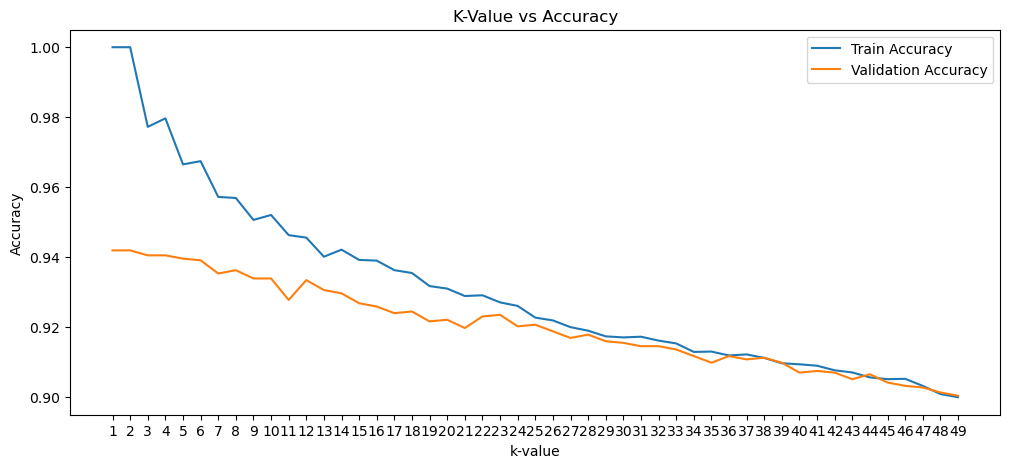

Best k-value: 1
Max Validation accuracy: 0.9418714555765595
Max Training accuracy: 1.0
-------------------------------------------------------------------
------------------------------------------------------------------- 



In [72]:
# TODO: Implement a kNN classifier
class KNN:
    def _init_():
        pass
    def fit(X, y):
        pass
    def predict(X):
        pass

    def knn_still_faster(X_train, y_train, X_test, kvalue):
        tree = KDTree(X_train)
        y_pred_knn = []

        for test_point in X_test:
            # Query the k nearest neighbors
            dists, indices = tree.query([test_point], k=kvalue)  # Ensure k_nearest_labels is always an array
            if kvalue == 1:
                k_nearest_labels = [y_train[indices[0]]]
            else:
                k_nearest_labels = y_train[indices[0]]
            most_common = Counter(k_nearest_labels).most_common(1)
            y_pred_knn.append(most_common[0][0])

        return np.array(y_pred_knn)

    train_accuracies = []
    val_accuracies = []
    y_train = np.array(train_dataset['labels'])
    X_train = np.array(train_dataset['feats'])
    y_val = np.array(val_dataset['labels'])
    X_val = np.array(val_dataset['feats'])
    k_values = range(1, 50, 1)

    knn = knn_still_faster

    for kvalue in tqdm(k_values, position=0, desc='k-values Progress'):
        y_pred_train = knn(X_train, y_train, X_train, kvalue)
        y_pred_test = knn(X_train, y_train, X_val, kvalue)

        # Calculate accuracy
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_val, y_pred_test)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(test_accuracy)

        #print(f'Training Accuracy for {kvalue} is {train_accuracy}')
        #print(f'Testing Accuracy for {kvalue} is {test_accuracy}')

    print('-------------------------------------------------------------------')

    # We plot the results of our KNN classifier to see how the accuracy changes with the value of kvalue on both
    # training and test data sets, and see where the underfitting and overfitting regions are.
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(k_values, train_accuracies, label='Train Accuracy')
    plt.plot(k_values, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('K-Value vs Accuracy')
    plt.xlabel('k-value')
    plt.ylabel('Accuracy')
    plt.xticks(list(k_values))  # Ensure that x-axis ticks match k values
    plt.show()

    # Print the k value and accuracy associated with the best performance on the test set
    max_accuracy_index = np.argmax(val_accuracies)
    best_k = k_values[max_accuracy_index]
    max_accuracy = val_accuracies[max_accuracy_index]

    print('Best k-value:', best_k)
    print('Max Validation accuracy:', max_accuracy)
    print('Max Training accuracy:', train_accuracies[max_accuracy_index])

    print('-------------------------------------------------------------------')
    print('------------------------------------------------------------------- \n')

## Part 2(d): MLP

Train an MLP classifier and report your classifier's accuracy on the training and validation sets. **You are allowed to use sklearn.neural_network.MLPClassifier for this section.** Make sure to run in all code you used to train and test your MLP classifier. See https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html for details.

In [18]:
from sklearn.neural_network import MLPClassifier

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (20,50,30), (30,100,50)],
#    'hidden_layer_sizes':[(100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPClassifier(max_iter=100, random_state=42)
# Create the split index (-1 for training set, 0 for validation set)
test_fold = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_val.shape[0])]
ps = PredefinedSplit(test_fold=test_fold)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=parameter_space, cv=ps, scoring='accuracy', return_train_score=True, verbose=0)

# Fit GridSearchCV
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)

# Access the best score and corresponding training score
best_validation_score = grid_search.best_score_
best_index = grid_search.best_index_
best_training_score = grid_search.cv_results_['mean_train_score'][best_index]

print(f"Best Validation Score: {best_validation_score}")
print(f"Corresponding Training Score: {best_training_score}")
# TODO: Train an MLPClassifier and report training and validation set accuracies

/Users/prateek/anaconda3/envs/AnacondaTest/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/prateek/anaconda3/envs/AnacondaTest/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/prateek/anaconda3/envs/AnacondaTest/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/prateek/anaconda3/envs/AnacondaTest/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimiza

Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best Validation Score: 0.9664461247637051
Corresponding Training Score: 0.995240988254354


/Users/prateek/anaconda3/envs/AnacondaTest/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


## Part 2(f): Bakeoff: Choose the best Classifier

For this section, you are free to use a classifier of your choice (you are allowed to use any libraries of your choice). You are also free to use the training and validation sets in any way you choose i.e. you can merge them and perform k-fold cross validation. <br>

To evaluate your classifier, we will on March 15th provide you with a pickle file ('test.pkl') that will be in the same format as the 'train.pkl' and 'val.pkl' but **will not contain the labels**. You will need to generate predictions for each of the inputs we provide in 'test.pkl' in a text file. <br>

For your submission, you will need to provide us with a  **test_predictions.txt** file containing the class predictions of your classifier. We will compute the accuracy of the predictions you provide for your evaluation.

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold

#pred = []
with open('datasets/test_data.pkl', 'rb') as f:
    test_dataset = pickle.load(f)
#print(X.shape)
#print(y.shape)
mlp_classifier = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate='constant', solver='adam', max_iter=500, random_state=40)
'''
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    mlp_classifier.fit(X_train, y_train)
    predictions = mlp_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracies.append(accuracy)

print(f"Accuracy scores for each fold: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies)}")
'''
print(X.shape)
print(y.shape)
mlp_classifier.fit(X,y)
pred = mlp_classifier.predict(np.array(test_dataset['feats']))
print(pred.shape)
print(pred)

# TODO: Train a classifier and generate predictions on the test set and put your predictions in pred.
# ...

# Make sure that pred contains a 1-dimensional integer array of class labels for the test set and make sure that
# every integer is in the range 0 through 14. If you have an entry in this array outside of the integer
# range of 0 through 14, it will be assumed to be an error. Also, if your array is not the length of the test
# set that will be assumed to be an error. Specifically, suppose n_mine is the length of the array of integers
# you turn in. If the test set has n_test images (meaning 
# it is an n_test X m matrix), then if your array is less than n_test long (so n_mine < n_test, then any missing 
# images will be assumed to be an error, so there will be n_test - n_mine errors. If your array is longer than 
# n_test images long, so that n_mine > n_test, then we will take the final n_mine - n_test images, whatever
# your predictions are for those images, and assume that those n_mine - n_test images are in error. Bottom line:
# make sure your array is exactly the right length, meaning you should have n_mine == n_test. Meaning,
# the array pred should be a one-dimensional integer array with integers in the 0-14 range
# of length n_mine. You can make sure that pred is of integer type by doing `pred = pred.astype(np.int32)` but
# after you do this, make sure to examine the result to ensure that they are integers in the right range.
#
# Note that the saved text file should have one prediction per ASCII line (this can be done by ensuring that pred 
# is of shape (n_test,) and then simply using np.savetxt).
#
#np.savetxt('test_predictions.txt', pred)


(11992, 15)
(11992,)
(2116,)
[3 9 3 ... 5 4 9]


[3 9 3 ... 5 4 9]


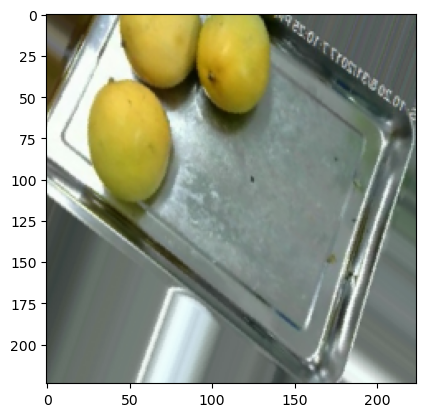

In [51]:
print(np.transpose(pred))
plt.imshow(test_dataset['images'][-3])
np.savetxt('test_predictions.txt', pred, fmt='%d')